In [1]:
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from typing import List, Dict, Union
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from PIL import Image
from torch.utils.data.dataset import random_split

In [2]:
DATA_DIR: str = "datasets"
RES_DIR: str = "results"
IMG_SIZE: int = 224
NUM_FRAMES_PER_VIDEO: int = 16
targets: Dict[str, int] = {"1": 0, "2": 0, "3": 1, "4": 1, "5": 2, "6": 2, \
    "7": 3, "8": 3, "HR_1": 0, "HR_2": 1, "HR_3": 2, "HR_4": 3}

def video2frames(video_path: str, resize: Union[int, int] = (IMG_SIZE, IMG_SIZE)) -> np.array:
    cap = cv2.VideoCapture(video_path)
    frames: list = []
    is_there_frame: bool = True
    num_total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    resampling_rate: int = int(num_total_frames / NUM_FRAMES_PER_VIDEO)
    idf: int = 0
    while is_there_frame and len(frames) < NUM_FRAMES_PER_VIDEO:
        idf += 1
        is_there_frame, frame = cap.read()
        if frame is None: 
            return np.array([])
        if idf % resampling_rate == 0:
            # grayscale
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # resize
            frame = cv2.resize(frame, resize)
            frames.append(frame)
    assert len(frames)==NUM_FRAMES_PER_VIDEO
    return np.array(frames)

def load_casia_dataset(subpath: str) -> Union[list, list]:
    try:
        num_folders: int = 1
        dataset_x: list = []
        dataset_y: list = []
        files = glob.glob(f'{DATA_DIR}/{subpath}/**/*.avi', recursive=True)
        for f in files:
            frames: np.array = video2frames(f)
            if frames.size != 0:
                dataset_x = [*dataset_x, *frames]
                dataset_x = np.array(dataset_x)
                vector_path: List[str] = f.split("\\")
                tmp = [targets[vector_path[-1][:-4]]]*NUM_FRAMES_PER_VIDEO
                dataset_y = [*dataset_y, *tmp]
    except LookupError: # IndexError, KeyError
        print("index from video name not found in map targets")
    return dataset_x, dataset_y

In [3]:
x_train, y_train = load_casia_dataset("train_release")

In [4]:
x_test, y_test = load_casia_dataset("test_release")

In [5]:
types: List[str] = set(targets.values())
types

{0, 1, 2, 3}

In [6]:
tensor_y_train = torch.as_tensor(y_train)
tensor_y_test = torch.as_tensor(y_test)

In [7]:
class MyDataset(Dataset):
    def __init__(self, list_IDs, labels):
        self.list_IDs = list_IDs
        self.labels = labels

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        X = preprocess(Image.fromarray(ID))
        y = self.labels[index]
        return X, y

In [21]:
batch_size: int = 32
len_y_train: int = len(y_train)
data_train: MyDataset = MyDataset(x_train, tensor_y_train)
data_test: MyDataset = MyDataset(x_test, tensor_y_test)
data_train, data_val = random_split(dataset=data_train, lengths=[round(len_y_train*0.8), round(len_y_train*0.2)])

In [22]:
train_loader: DataLoader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=data_val, batch_size=batch_size, shuffle=False)
test_loader: DataLoader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

In [23]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for e in resnet101.parameters():
   e.requires_grad = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet101.fc = nn.Linear(in_features=2048, out_features=len(types), bias=True)
optimizer = optim.SGD(resnet101.parameters(), lr=1e-4, weight_decay=0.005, momentum=0.9)
resnet101.to(device)

In [25]:
def train(model, optimizer, loss_fn, num_epochs) -> Union[List[float], List[float]]:
  # train the model
  list_train_loss: List[float] = []
  list_val_loss: List[float] = []

  beg = time.time()
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      # forward 
      output = model(images)
      loss   = loss_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # del images, labels, output
    
    train_loss: float = loss.item()
    list_train_loss.append(train_loss)
    with torch.no_grad():
        model.eval()
        for images, labels in val_loader:
          correct = 0
          total = 0
          for images, labels in val_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              loss = loss_fn(outputs, labels)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
              del images, labels, outputs

        val_loss: float = loss.detach().cpu()
        list_val_loss.append(val_loss)
        print ('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss {:.4f},  Accuracy: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, val_loss, 100*correct/total))
  end = time.time()
  print('Finished training trainset in {} seconds'.format(round(end-beg, 2)))

  return list_train_loss, list_val_loss

In [26]:
def test(model, save_name: str = ""):
    with torch.no_grad():
        all_predicted: list = []
        all_labels: list = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predicted.extend((predicted).tolist())
            all_labels.extend((labels).tolist())
        matrix = confusion_matrix(all_labels, all_predicted)
        df = pd.DataFrame(matrix, index=types, columns=types)
        sns.heatmap(df, annot=True, cbar=None, cmap="Greens")
        plt.title("Confusion Matrix"), plt.tight_layout()
        plt.xlabel("Predicted")
        plt.ylabel("Real")
        if save_name == "":
            plt.show()
        else:
            plt.savefig(RES_DIR+save_name)
        print('Test of the model on the {} test images'.format(len(data_test)))
        print('Acurracy: {:.2f} %'.format(100*accuracy_score(all_labels, all_predicted)))
        print('F1-score: {:.2f} %'.format(100*f1_score(all_labels, all_predicted, average='macro')))
        print('Recall: {:.2f} %'.format(100*recall_score(all_labels, all_predicted, average='macro')))
        print('Precision: {:.2f} %'.format(100*precision_score(all_labels, all_predicted, average='macro')))


In [32]:
train_loss_resnet101, val_loss_resnet101 = train(resnet101, optimizer, loss_fn, 5)

Epoch [1/5], Train Loss: 1.1138, Validation Loss 1.1450,  Accuracy: 75.1969
Epoch [2/5], Train Loss: 0.8771, Validation Loss 0.8774,  Accuracy: 87.9265
Epoch [3/5], Train Loss: 0.8278, Validation Loss 0.6867,  Accuracy: 91.6010
Epoch [4/5], Train Loss: 0.7192, Validation Loss 0.5856,  Accuracy: 92.7822
Epoch [5/5], Train Loss: 0.5852, Validation Loss 0.4940,  Accuracy: 92.7822
Finished training trainset in 509.09 seconds


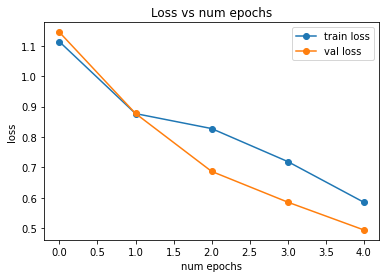

In [35]:
plt.plot(train_loss_resnet101, marker='o', label="train loss")
plt.plot(val_loss_resnet101, marker='o', label="val loss")
plt.ylabel("loss")
plt.xlabel("num epochs")
plt.title("Loss vs num epochs")
plt.legend()
plt.savefig(RES_DIR+"/loss.png")

Test of the model on the 5744 test images
Acurracy: 85.48 %
F1-score: 85.08 %
Recall: 85.52 %
Precision: 87.50 %


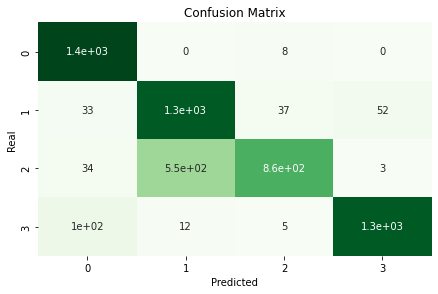

In [36]:
test(resnet101, "/confusion_matrix.png")

In [41]:
MODEL_DIR: str = "models"
torch.save(resnet101.state_dict(), MODEL_DIR+"/resnet101.pt")